C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Loss: 0.4946959162580556, Train Accuracy: 0.8474945533769063, Test Accuracy: 0.8446601941747572
Epoch [2/10], Loss: 0.18644217658659507, Train Accuracy: 0.9596949891067538, Test Accuracy: 0.970873786407767
Epoch [3/10], Loss: 0.09758654532247577, Train Accuracy: 0.9793028322440087, Test Accuracy: 0.9805825242718447
Epoch [4/10], Loss: 0.06634821656063714, Train Accuracy: 0.9923747276688453, Test Accuracy: 0.970873786407767
Epoch [5/10], Loss: 0.04956067695507202, Train Accuracy: 0.9912854030501089, Test Accuracy: 0.9902912621359223
Epoch [6/10], Loss: 0.039374088145920944, Train Accuracy: 0.9945533769063181, Test Accuracy: 0.9805825242718447
Epoch [7/10], Loss: 0.03734532777412698, Train Accuracy: 0.9934640522875817, Test Accuracy: 0.9902912621359223
Epoch [8/10], Loss: 0.02136081801566841, Train Accuracy: 0.9869281045751634, Test Accuracy: 0.9902912621359223
Epoch [9/10], Loss: 0.037707170118288745, Train Accuracy: 0.9847494553376906, Test Accuracy: 0.9902912621359223
Ep

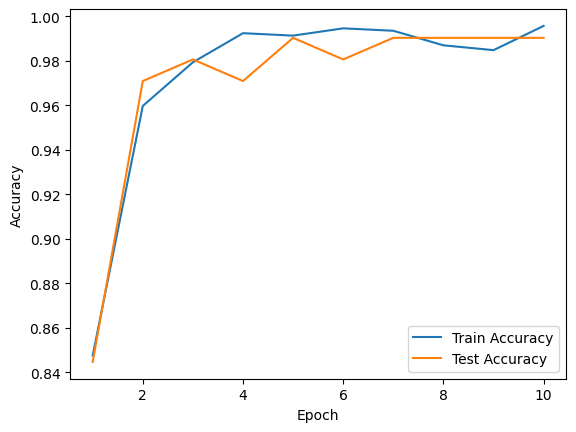

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Определение преобразований
transform = transforms.Compose([
    transforms.Resize((60, 120)),  # Изменяем размер изображений
    transforms.ToTensor()  # Преобразуем изображения в тензоры
])

# Загрузка данных
data_dir = 'classification_region_type'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Разделение данных на тренировочный и тестовый наборы
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 30 * 15, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 15)  # Изменяем размер тензора для Fully Connected слоя
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция для вычисления точности
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

# Обучение модели
num_epochs = 10
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        
        outputs = model(inputs)  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисление ошибки
        loss.backward()  # Обратный проход
        optimizer.step()  # Обновление параметров
        
        running_loss += loss.item()
    
    train_acc = calculate_accuracy(train_loader, model)
    test_acc = calculate_accuracy(test_loader, model)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_acc}, Test Accuracy: {test_acc}')

# Сохранение весов модели
torch.save(model, 'model_weights.pth')

# Визуализация точности
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

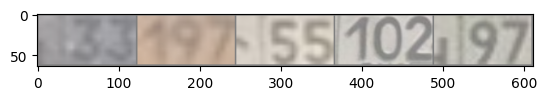

GroundTruth:  0 1 0 1 0
Predicted:  0 1 0 1 0


In [2]:
# Отображение предсказаний на тестовом наборе
model.eval()
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Функция для отображения изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Отображение первых 5 тестовых изображений и их предсказаний
imshow(utils.make_grid(images[:5]))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(5)))
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(5)))

# Код для получения предсказания по изображению/папке с изображениями

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
import os


# Определение модели
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 30 * 15, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 15)  # Изменяем размер тензора для Fully Connected слоя
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Загрузка модели
model = torch.load('model_weights.pth')
model.eval()

# Функция для предсказания на изображении
def predict_image(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((60, 120)),
        transforms.ToTensor()
    ])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование BGR изображения OpenCV в RGB
    image = transform(image).unsqueeze(0)  # Применение преобразований и добавление измерения batch
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

path = r'F:\grozny\beeline\train_borders\align\02b326fe0ea901d6.jpg'
image = cv2.imread(path)
prediction = predict_image(image)
print(f'Predicted class: {prediction}')
    
# path = r'classification_region_type\3'
# # Пример использования
# for name in os.listdir(path):
#     image_path = os.path.join(path, name)
#     image = cv2.imread(image_path)
#     prediction = predict_image(image)
#     print(f'Predicted class: {prediction}')


C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted class: 0


C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import os
from PIL import Image

# Определение модели (замените на вашу модель)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 30 * 15, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 15)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Загрузка модели
model = torch.load('model_weights.pth')
model.eval()

# Преобразования для изображения
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((60, 120)),
    transforms.ToTensor()
])

# Координатные шаблоны
two_digit_region_template = [
    {'pos': 1, 'p1': (0.067, 0.250), 'p2': (0.177, 0.92)},
    {'pos': 2, 'p1': (0.19, 0.100), 'p2': (0.3, 0.92)},
    {'pos': 3, 'p1': (0.3, 0.100), 'p2': (0.41, 0.92)},
    {'pos': 4, 'p1': (0.41, 0.100), 'p2': (0.52, 0.92)},
    {'pos': 5, 'p1': (0.53, 0.250), 'p2': (0.64, 0.92)},
    {'pos': 6, 'p1': (0.64, 0.250), 'p2': (0.75, 0.92)},
    {'pos': 7, 'p1': (0.77, 0.05), 'p2': (0.86, 0.7)},
    {'pos': 8, 'p1': (0.86, 0.05), 'p2': (0.95, 0.7)}
]
three_digit_region_template = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

# Функция для предсказания класса изображения
def predict_class(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Функция для извлечения фрагментов
def extract_fragments(image, template, save_dir, image_name):
    height, width = image.shape[:2]
    for region in template:
        p1 = (int(region['p1'][0] * width), int(region['p1'][1] * height))
        p2 = (int(region['p2'][0] * width), int(region['p2'][1] * height))
        fragment = image[p1[1]:p2[1], p1[0]:p2[0]]
        fragment = cv2.resize(fragment, (50, 70))
        fragment_name = f"{image_name}_pos{region['pos']}.png"
        cv2.imwrite(os.path.join(save_dir, fragment_name), fragment)

# Основной код
input_dir = 'F:/grozny/beeline/train_borders/align'
output_dir = 'F:/grozny/beeline/train_borders/fragments'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(input_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
#         print(filename)
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)
        image_class = predict_class(image)
        image_name, _ = os.path.splitext(filename)
        
        if image_class == 0:
            extract_fragments(image, two_digit_region_template, output_dir, image_name)
        elif image_class == 1:
            extract_fragments(image, three_digit_region_template, output_dir, image_name)


C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
import os
import cv2
import numpy as np

class LettersPrediction(object):
    def __init__(self):
        self.model = resnet18()
        self.model.fc = nn.Linear(self.model.fc.in_features, out_features=22)
        self.model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cuda')))
        self.model.eval()

        self.imgsz = 64

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.imgsz, self.imgsz)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img):
        input_tensor = self.transform(img)
        output_tensor = self.model(input_tensor.unsqueeze(0))
        predicted = torch.argmax(output_tensor)
        return label2letter[predicted.item()]

    def predict_series(self, imgs):
        s = ""
        for img in imgs:
            s += self.predict(img)
        return s
    
label2letter = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "A", 11: "B", 12: "C", 13: "E", 14: "H", 15: "K", 16: "M", 17: "O", 18: "P", 19: "T", 20: "X", 21: "Y"
}
MODEL_PATH = r'F:\grozny\beeline\resnet18_letters.pth'
model = LettersPrediction()


C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


X


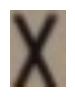

0


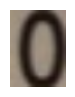

5


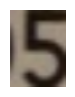

1


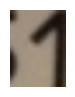

H


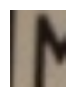

H


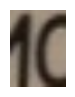

H


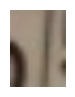

5


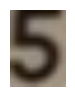

1


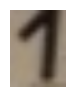

B


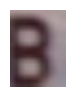

6


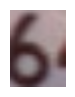

4


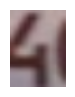

0


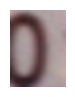

M


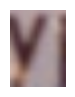

C


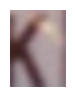

8


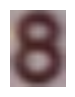

2


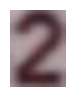

P


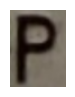

8


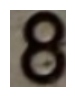

1


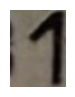

7


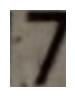

H


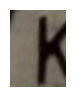

1


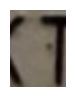

4


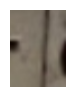

6


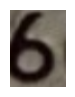

0


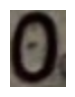

B


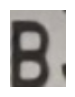

3


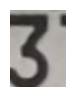

7


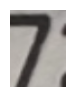

2


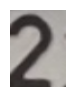

X


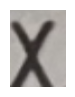

X


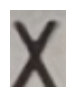

1


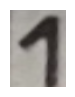

9


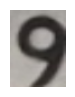

8


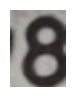

O


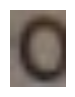

8


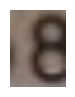

9


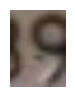

O


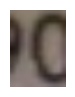

M


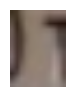

T


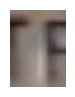

0


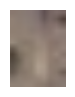

3


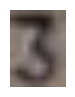

1


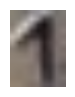

C


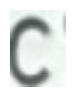

9


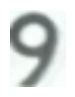

7


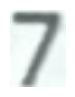

1


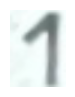

E


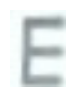

C


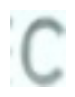

1


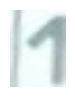

7


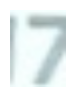

8


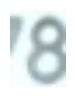

A


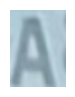

8


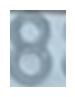

8


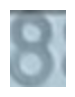

8


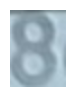

C


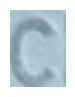

M


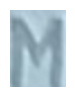

1


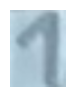

5


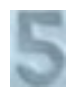

4


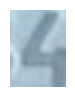

C


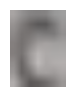

1


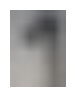

4


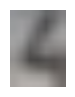

6


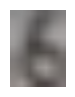

0


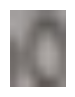

C


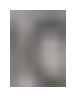

1


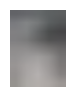

5


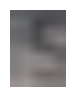

4


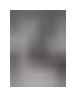

1


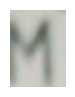

7


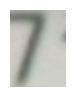

T


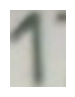

7


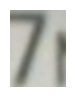

M


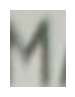

A


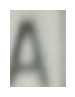

7


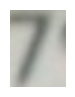

9


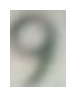

7


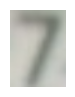

T


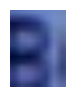

2


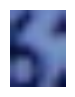

2


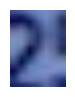

7


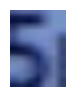

T


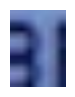

1


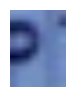

T


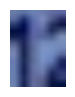

4


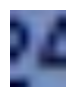

B


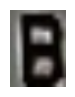

6


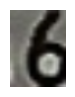

2


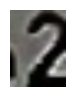

6


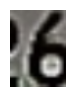

M


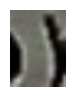

H


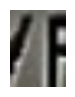

Y


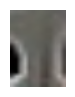

6


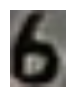

4


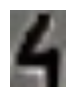

C


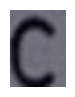

8


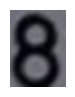

2


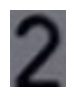

4


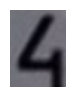

K


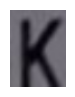

Y


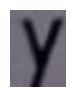

M


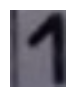

9


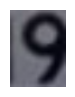

7


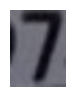

T


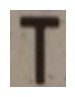

1


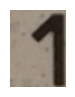

9


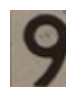

1


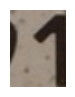

E


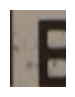

C


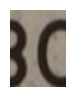

H


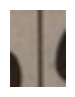

6


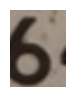

4


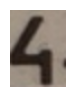

P


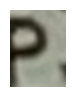

3


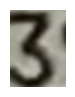

9


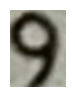

6


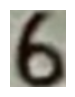

0


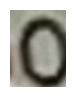

C


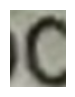

T


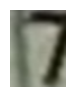

9


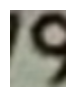

0


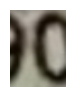

A


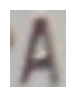

8


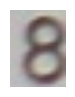

5


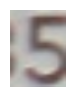

4


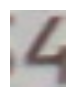

E


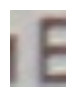

2


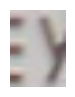

1


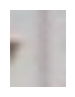

1


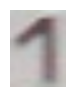

7


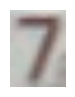

B


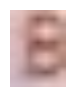

2


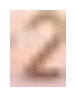

5


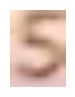

6


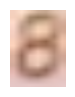

P


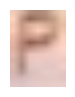

P


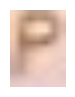

1


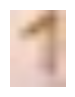

7


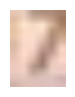

8


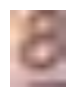

O


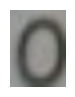

0


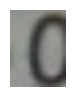

0


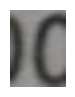

5


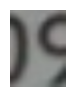

H


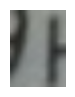

H


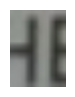

1


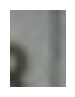

3


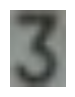

9


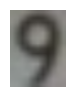

H


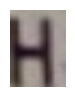

3


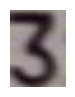

9


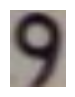

9


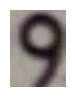

K


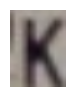

C


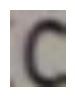

1


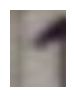

3


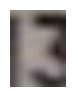

4


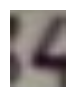

0


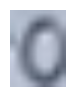

1


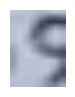

T


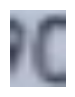

T


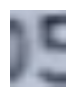

1


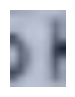

0


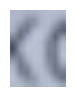

1


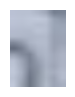

6


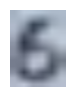

0


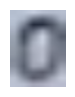

M


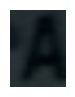

K


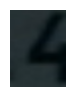

7


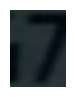

3


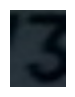

1


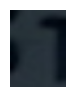

H


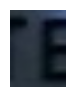

H


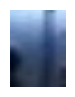

2


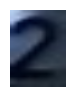

2


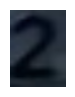

O


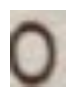

5


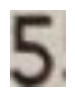

5


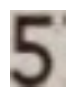

7


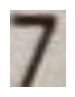

H


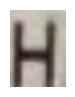

M


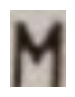

1


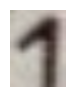

2


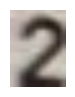

4


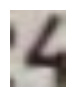

B


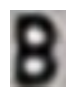

9


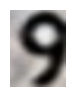

8


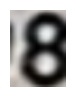

M


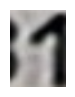

8


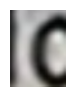

X


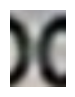

1


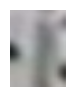

3


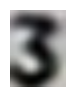

7


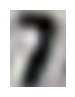

X


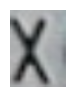

6


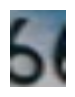

4


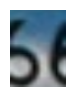

4


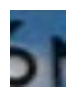

M


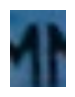

M


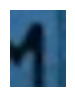

7


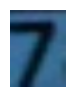

8


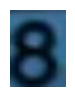

B


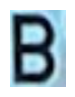

9


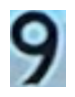

7


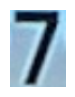

9


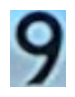

E


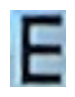

E


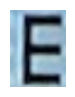

1


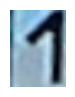

9


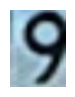

6


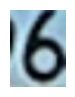

O


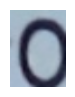

6


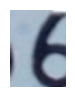

2


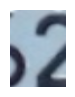

2


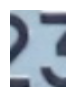

2


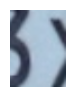

1


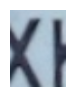

1


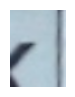

3


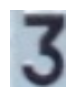

6


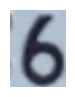

Y


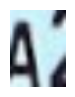

7


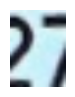

T


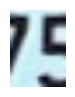

4


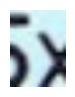

T


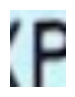

T


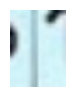

9


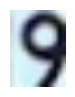

0


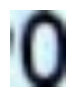

Y


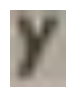

3


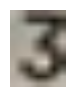

4


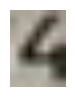

6


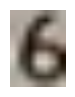

C


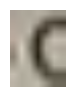

1


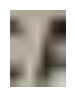

T


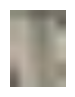

3


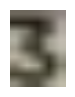

1


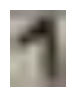

E


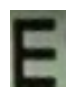

0


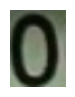

0


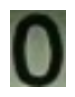

4


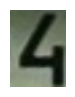

C


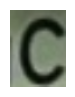

P


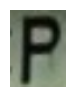

7


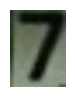

5


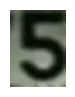

0


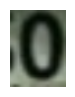

H


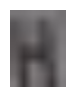

0


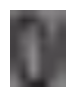

0


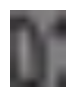

2


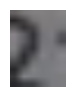

H


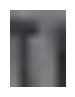

H


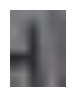

2


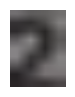

3


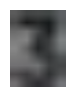

H


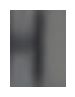

T


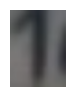

Y


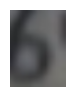

9


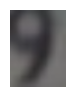

C


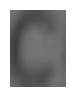

0


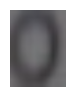

A


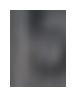

1


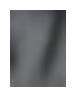

A


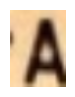

5


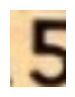

8


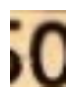

E


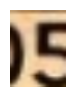

M


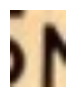

M


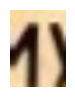

1


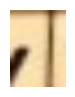

1


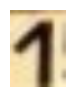

5


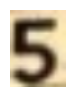

H


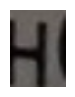

Y


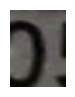

5


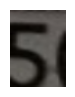

O


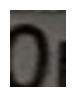

M


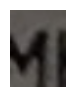

H


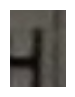

M


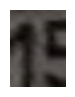

4


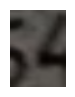

T


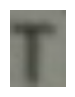

7


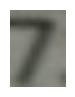

2


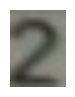

1


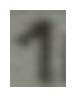

8


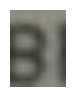

H


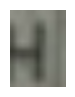

M


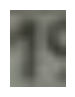

Y


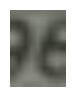

A


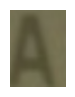

0


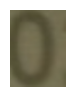

2


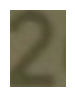

6


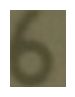

C


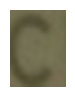

E


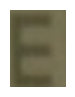

5


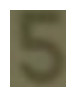

1


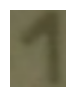

H


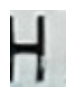

2


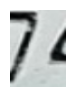

4


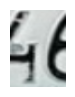

4


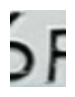

1


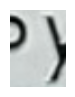

1


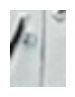

E


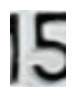

0


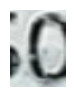

C


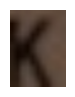

M


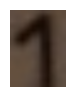

8


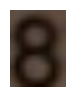

7


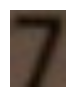

C


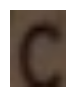

T


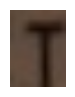

1


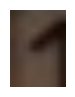

9


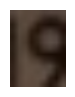

6


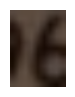

X


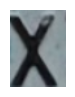

2


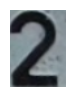

7


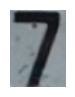

8


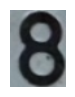

X


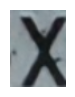

T


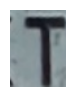

M


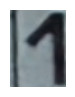

7


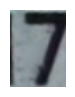

8


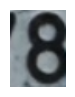

P


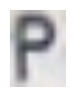

4


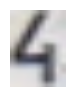

3


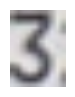

2


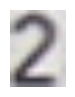

B


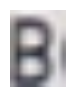

O


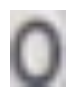

1


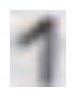

9


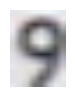

0


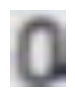

K


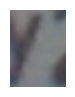

2


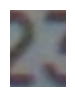

X


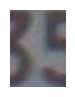

Y


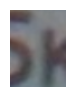

T


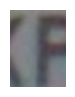

M


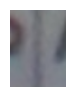

5


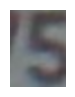

0


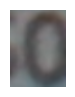

P


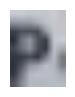

4


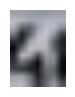

Y


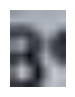

Y


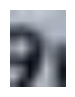

C


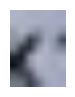

H


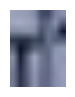

1


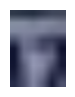

H


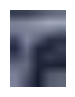

C


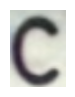

3


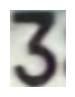

8


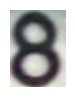

9


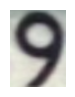

K


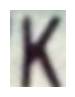

P


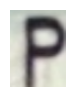

1


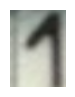

7


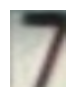

8


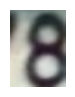

Y


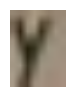

T


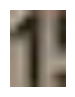

4


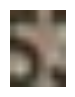

Y


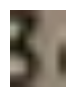

Y


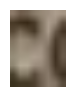

Y


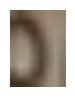

3


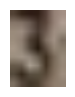

1


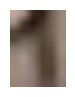

M


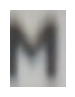

2


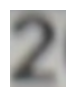

O


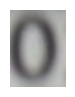

2


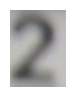

X


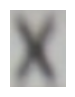

T


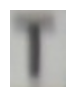

4


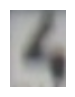

4


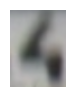

C


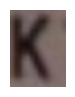

M


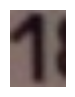

8


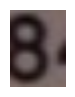

4


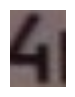

P


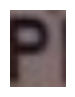

E


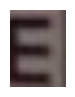

7


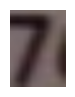

6


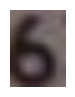

3


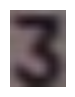

T


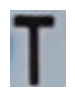

7


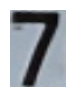

0


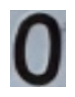

9


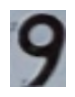

Y


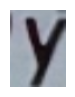

B


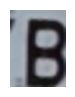

1


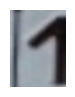

7


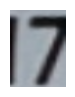

8


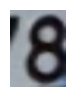

T


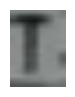

3


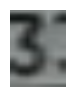

Y


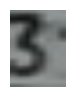

T


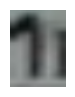

H


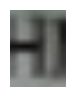

M


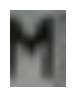

1


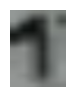

7


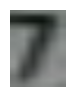

B


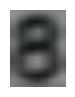

M


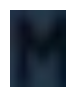

9


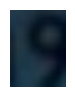

M


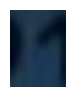

K


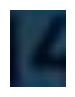

B


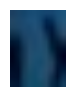

1


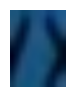

T


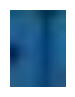

T


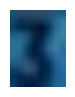

1


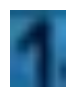

C


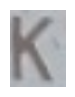

9


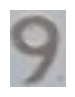

6


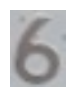

1


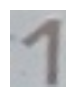

B


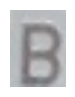

T


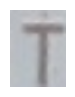

7


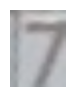

9


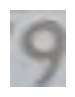

7


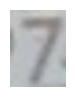

4


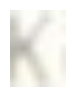

1


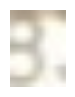

7


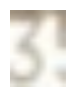

4


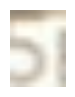

1


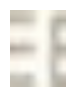

1


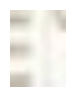

7


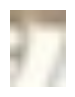

7


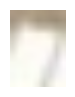

Y


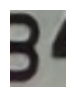

4


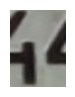

4


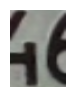

H


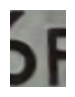

1


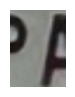

H


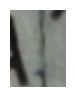

9


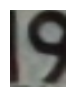

8


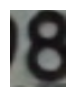

B


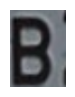

2


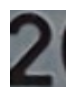

0


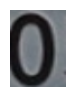

5


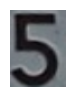

E


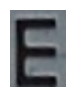

B


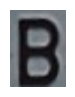

7


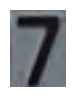

7


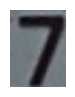

4


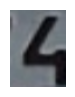

X


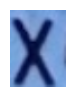

6


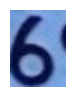

9


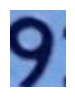

2


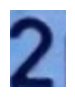

E


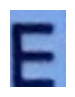

C


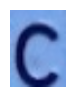

1


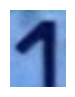

2


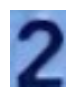

4


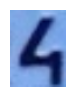

M


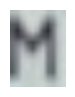

7


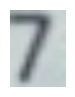

1


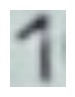

0


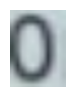

H


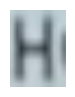

C


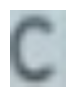

7


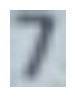

5


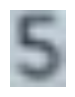

0


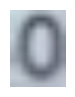

T


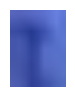

7


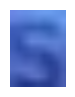

7


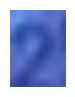

7


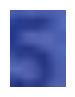

7


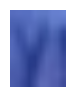

1


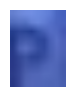

7


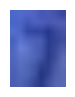

1


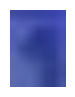

C


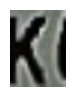

6


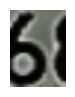

8


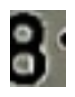

M


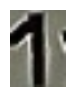

M


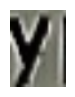

E


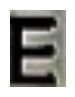

1


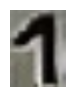

6


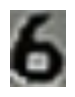

4


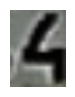

B


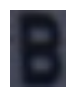

0


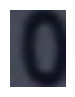

0


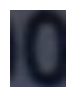

M


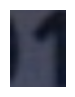

H


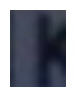

C


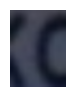

H


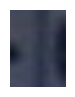

0


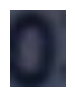

3


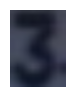

O


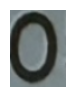

5


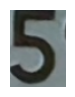

9


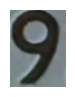

2


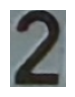

M


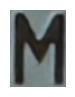

T


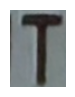

1


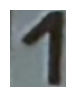

9


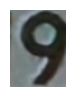

8


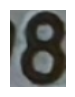

5


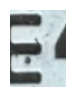

4


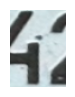

2


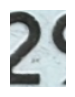

T


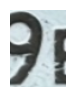

8


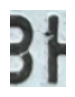

H


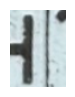

P


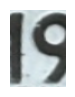

8


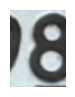

A


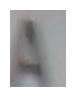

T


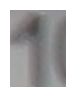

T


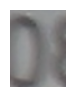

8


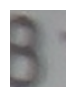

T


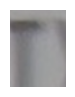

Y


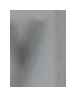

3


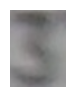

7


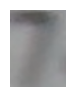

E


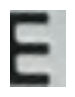

7


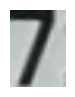

2


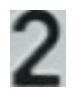

7


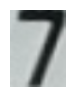

T


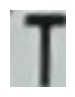

T


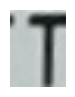

H


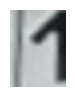

9


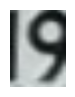

8


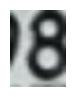

B


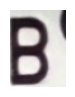

9


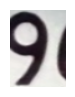

6


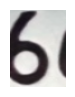

6


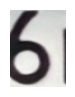

E


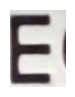

O


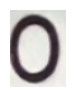

1


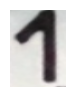

4


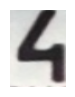

7


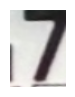

C


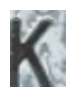

0


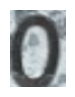

7


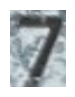

5


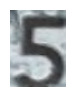

K


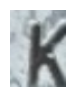

0


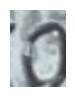

9


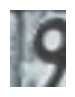

9


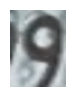

7


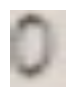

5


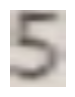

0


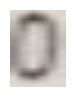

5


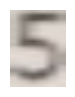

E


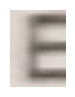

7


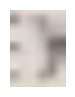

1


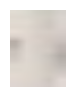

5


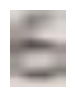

4


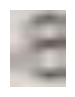

Y


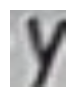

1


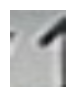

T


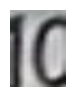

7


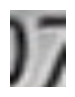

H


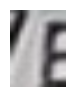

H


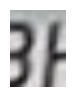

1


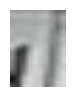

5


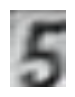

6


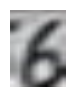

E


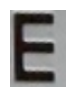

7


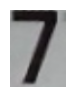

7


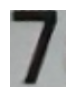

6


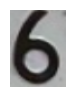

Y


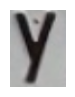

K


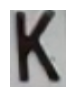

1


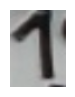

9


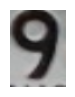

8


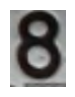

H


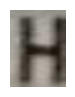

7


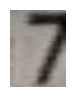

8


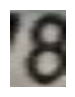

7


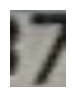

H


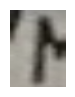

M


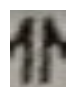

H


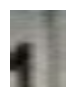

3


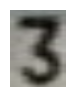

0


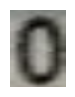

C


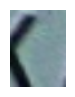

T


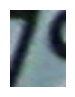

9


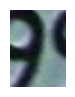

9


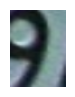

M


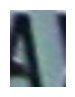

M


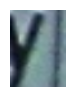

T


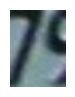

X


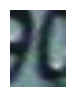

B


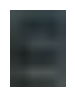

X


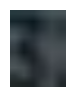

2


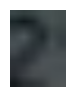

H


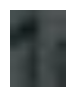

1


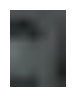

M


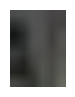

M


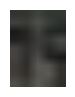

M


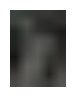

M


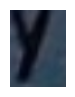

6


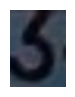

4


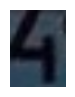

9


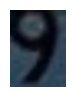

A


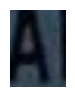

E


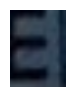

M


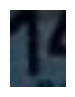

K


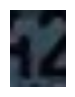

H


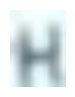

9


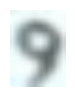

3


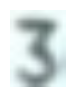

6


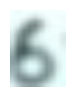

Y


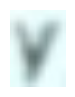

A


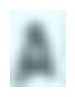

1


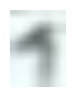

7


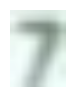

6


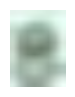

B


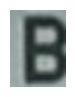

2


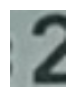

8


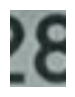

2


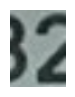

1


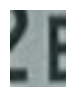

B


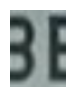

1


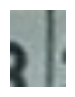

4


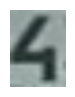

3


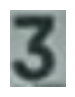

T


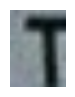

0


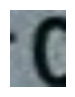

M


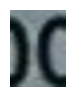

Y


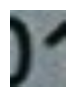

H


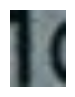

Y


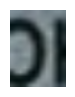

H


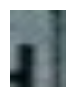

9


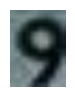

7


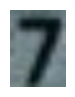

O


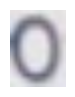

1


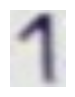

8


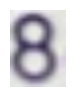

6


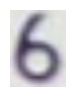

Y


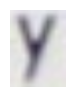

H


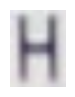

1


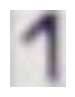

6


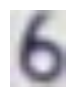

3


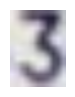

K


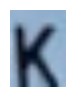

3


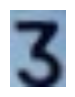

8


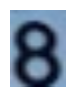

0


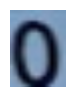

T


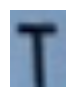

X


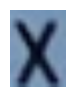

9


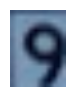

8


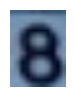

E


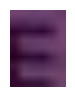

4


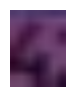

2


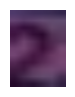

2


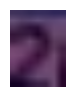

0


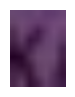

M


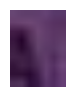

H


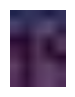

Y


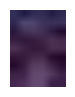

C


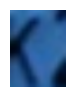

2


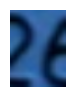

3


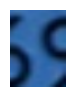

X


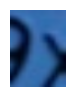

1


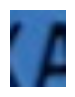

T


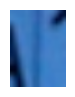

7


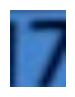

8


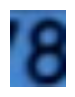

X


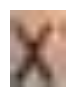

Y


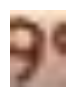

Y


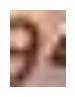

4


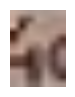

Y


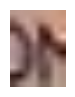

H


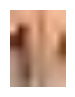

9


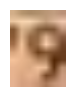

9


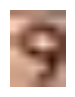

A


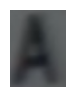

0


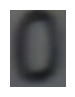

7


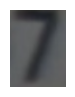

7


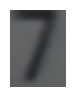

A


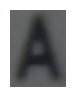

X


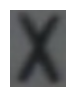

3


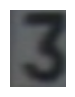

7


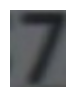

B


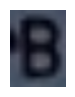

1


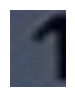

3


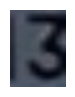

2


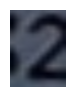

M


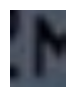

M


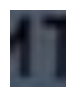

H


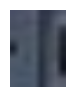

0


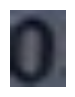

3


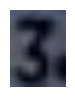

E


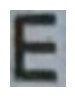

0


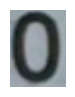

9


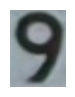

2


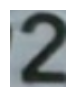

B


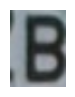

P


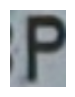

7


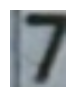

7


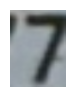

7


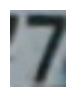

A


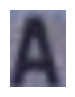

1


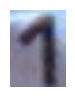

5


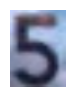

6


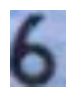

C


KeyboardInterrupt: 

<Figure size 100x100 with 0 Axes>

In [5]:
from matplotlib import pyplot as plt

input_dir = 'F:/grozny/beeline/train_borders/fragments'


for filename in os.listdir(input_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
#         print(filename)
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)
#         print(image[:][:].shape)
        image_class = model.predict_series(torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0))
        print(image_class)
        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.axis('off')  # Убираем оси для чистого вида
        plt.show()
